# Progress:

1. Beat-level ECG classification 

2. Patient-level ECG severity modeling

3. Temporal severity progression

4. ECG + EHR fusion

5. Disease progression prediction

# 1. Beat-Level ECG Classification

## PHASE 1: Understand MIT-BIH

Each record (like 111, 112, etc.) has:

| File   | Meaning                                |
| ------ | -------------------------------------- |
| `.dat` | Raw ECG signal                         |
| `.hea` | Signal metadata (sampling rate, leads) |
| `.atr` | Expert-labeled beat annotations        |
| `.xws` | Ignore (WFDB workspace file)           |

💡 Key fact
MIT-BIH annotations tell you: “At this exact sample index, this beat type occurs”

## PHASE 2: Define the Beat Classes

MIT-BIH has ~15 beat types. Research papers usually group them as:

| Symbol | Meaning                    |
| ------ | -------------------------- |
| N      | Normal                     |
| L      | Left bundle branch block   |
| R      | Right bundle branch block  |
| A      | Atrial premature           |
| V      | Ventricular premature      |
| F      | Fusion                     |
| /      | Paced                      |
| f      | Fusion of paced & normal   |
| E      | Ventricular escape         |
| j      | Nodal escape               |
| a      | Atrial escape              |
| S      | Supraventricular premature |
| Q      | Unclassifiable             |
| !      | Ventricular flutter        |
| x      | Non-conducted P-wave       |


### STEP 1️: Imports & global settings

In [69]:
import os
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
from scipy.stats import linregress
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

### STEP 2️: Define dataset path & records list

In [71]:
# Dataset path
DATASET_PATH = "DATASET/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0"

# List all records
records = sorted(list(set([
    f.split('.')[0]
    for f in os.listdir(DATASET_PATH)
    if f.endswith('.dat')
])))
print(f"Total records found: {len(records)}")

Total records found: 48


### STEP 3️: Define beat extraction parameters

In [72]:
WINDOW_BEFORE = 0.2   # seconds before R-peak
WINDOW_AFTER  = 0.4   # seconds after R-peak


### STEP 4️: Beat extraction function (CORE LOGIC)

This is the heart of the ECG pipeline.

In [73]:
def extract_beats(record_name):
    """
    Extract individual heartbeats from ECG record
    """
    record_path = os.path.join(DATASET_PATH, record_name)
    
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, 'atr')
    
    signal = record.p_signal[:, 0]   # Use MLII lead
    fs = record.fs
    
    beats = []
    labels = []
    beat_times = []  # Store sample indices for temporal analysis
    
    win_before = int(WINDOW_BEFORE * fs)
    win_after  = int(WINDOW_AFTER * fs)
    
    for samp, sym in zip(annotation.sample, annotation.symbol):
        # Keep ALL meaningful beat symbols
        if sym.isalnum() or sym in ['/', '!', 'f', 'x']:
            start = samp - win_before
            end   = samp + win_after
            
            if start > 0 and end < len(signal):
                beat = signal[start:end]
                beats.append(beat)
                labels.append(sym)
                beat_times.append(samp)
    
    return beats, labels, beat_times, fs

### STEP 5: Clinical Beat Groupings

In [74]:
# Clinically meaningful beat groups (medical logic)
NORMAL = ['N']

# High-risk ventricular arrhythmias
VENTRICULAR = ['V', 'E', '!']        

# Moderate-risk atrial abnormalities  
ATRIAL = ['A', 'a', 'S']             

# Structural conduction issues
CONDUCTION = ['L', 'R']              

# Pacemaker-related rhythms
PACED = ['/', 'f']                   

# Rare / unclassified beats
OTHER = ['Q', 'x', 'j', 'F', 'J']    

# Beat severity weights for temporal analysis
BEAT_SEVERITY = {
    'N': 0.0,    # Normal
    'L': 0.4,    # Left bundle branch block
    'R': 0.4,    # Right bundle branch block
    'A': 0.3,    # Atrial premature
    'V': 0.6,    # Ventricular premature
    'F': 0.5,    # Fusion beat
    '/': 0.2,    # Paced beat
    'f': 0.2,    # Fusion of paced & normal
    'E': 0.7,    # Ventricular escape
    'j': 0.3,    # Nodal escape
    'a': 0.3,    # Atrial escape
    'S': 0.3,    # Supraventricular premature
    'Q': 0.5,    # Unclassifiable
    '!': 0.8,    # Ventricular flutter
    'x': 0.1     # Non-conducted P-wave
}

### STEP 6: Extract all beats

In [75]:
print("Extracting beats from all records...")
all_beats = []
all_labels = []
all_times = []
all_fs = []

for rec in records:
    print(f"Processing record {rec}...")
    beats, labels, times, fs = extract_beats(rec)
    all_beats.extend(beats)
    all_labels.extend(labels)
    all_times.extend(times)
    all_fs.append(fs)

print(f"\nTotal beats extracted: {len(all_beats)}")

Extracting beats from all records...
Processing record 100...
Processing record 101...
Processing record 102...
Processing record 103...
Processing record 104...
Processing record 105...
Processing record 106...
Processing record 107...
Processing record 108...
Processing record 109...
Processing record 111...
Processing record 112...
Processing record 113...
Processing record 114...
Processing record 115...
Processing record 116...
Processing record 117...
Processing record 118...
Processing record 119...
Processing record 121...
Processing record 122...
Processing record 123...
Processing record 124...
Processing record 200...
Processing record 201...
Processing record 202...
Processing record 203...
Processing record 205...
Processing record 207...
Processing record 208...
Processing record 209...
Processing record 210...
Processing record 212...
Processing record 213...
Processing record 214...
Processing record 215...
Processing record 217...
Processing record 219...
Processing re

### STEP 6️: Prepare Data for Model Training

In [76]:
# Convert to numpy array and normalize
X = np.array(all_beats)

# Z-score normalization per beat
X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-8)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(all_labels)

print("Classes found:")
for i, cls in enumerate(le.classes_):
    print(f"{i}: {cls}")

# Reshape for CNN (samples, time, channels)
X = X[..., np.newaxis]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"\nTrain shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Classes found:
0: !
1: /
2: A
3: E
4: F
5: J
6: L
7: N
8: Q
9: R
10: S
11: V
12: a
13: e
14: f
15: j
16: x

Train shape: (88100, 216, 1)
Test shape: (22025, 216, 1)


### STEP 7️:  Build and Train CNN Model

In [77]:
def build_cnn_model(input_shape, num_classes):
    """
    Build 1D CNN for beat classification
    """
    model = Sequential([
        Conv1D(32, kernel_size=5, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        
        Conv1D(64, kernel_size=5, activation='relu'),
        MaxPooling1D(2),
        
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(2),
        
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build model
num_classes = len(np.unique(y))
model = build_cnn_model((X.shape[1], 1), num_classes)
model.summary()

# Train model
history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=256,
    validation_split=0.1,
    verbose=1
)

# Save model
model.save('ecg_beat_classifier.h5')
print("\nModel saved as 'ecg_beat_classifier.h5'")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                   ┃ Output Shape           ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)              │ (None, 212, 32)        │          192 │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ max_pooling1d_3 (MaxPooling1D) │ (None, 106, 32)        │            0 │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ conv1d_4 (Conv1D)              │ (None, 102, 64)        │       10,304 │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ max_pooling1d_4 (MaxPooling1D) │ (None, 51, 64)         │            0 │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ conv1d_5 (Conv1D)              │ (None, 49, 128)        │       24,704 │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ max_pooling1d_5 (MaxPooling1D) │ (None, 24, 128)        │            0 │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ flatten_1 (Flatten)            │ (None, 3072)           │            0 │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ dense_2 (Dense)                │ (None, 256)            │      786,688 │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ dropout_1 (Dropout)            │ (None, 256)            │            0 │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ dense_3 (Dense)                │ (None, 17)             │        4,369 │
└────────────────────────────────┴────────────────────────┴──────────────┘

 Total params: 826,257 (3.15 MB)

 Trainable params: 826,257 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
310/310 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9194 - loss: 0.3283 - val_accuracy: 0.9687 - val_loss: 0.1213
Epoch 2/25
310/310 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9666 - loss: 0.1329 - val_accuracy: 0.9760 - val_loss: 0.0943
Epoch 3/25
310/310 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.9740 - loss: 0.1022 - val_accuracy: 0.9799 - val_loss: 0.0795
Epoch 4/25
310/310 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9775 - loss: 0.0859 - val_accuracy: 0.9821 - val_loss: 0.0674
Epoch 5/25
310/310 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9803 - loss: 0.0727 - val_accuracy: 0.9841 - val_loss: 0.0661
Epoch 6/25
310/310 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9827 - loss: 0.0655 - val_accuracy: 0.9857 - val_loss: 0.0614
Epoch 7/25
310/310 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9838 - loss: 0.0597 - val_accuracy: 0.9858 - val_loss: 0.0642
Epoch 8/25
310/310 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9850 - loss: 0.0546 - val_accu


Model saved as 'ecg_beat_classifier.h5'


### STEP 8️: Evaluate Model


Test Accuracy: 0.9885

Classification Report:
              precision    recall  f1-score   support

           !       0.95      0.87      0.91        94
           /       1.00      1.00      1.00      1405
           A       0.94      0.88      0.91       509
           E       1.00      0.81      0.89        21
           F       0.89      0.82      0.85       160
           J       0.94      0.88      0.91        17
           L       1.00      0.99      0.99      1614
           N       0.99      1.00      0.99     15006
           Q       0.00      0.00      0.00         7
           R       0.99      1.00      0.99      1451
           S       0.00      0.00      0.00         1
           V       0.98      0.97      0.97      1426
           a       0.91      0.70      0.79        30
           e       0.00      0.00      0.00         3
           f       0.98      0.97      0.98       196
           j       0.78      0.67      0.72        46
           x       1.00      0.92 

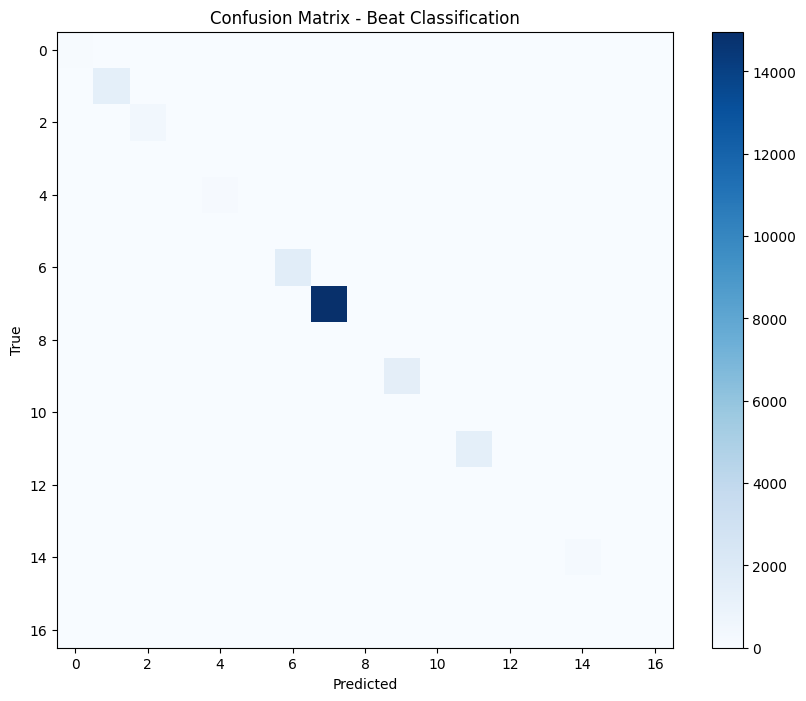

In [78]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Classification report
y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
print("\nClassification Report:")
print(classification_report(
    y_test, y_pred,
    target_names=le.classes_,
    zero_division=0
))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix - Beat Classification")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

### STEP 9️: Patient-Level ECG Metrics Computation

In [79]:
def predict_patient_beats(record_name, model, le):
    """
    Predict beat types for a single patient
    """
    beats, _, times, fs = extract_beats(record_name)
    
    if len(beats) == 0:
        return [], [], []
    
    beats_array = np.array(beats)
    
    # Normalize per beat
    beats_array = (beats_array - beats_array.mean(axis=1, keepdims=True)) / \
                  (beats_array.std(axis=1, keepdims=True) + 1e-8)
    
    beats_array = beats_array[..., np.newaxis]
    
    preds = np.argmax(model.predict(beats_array, verbose=0), axis=1)
    labels = le.inverse_transform(preds)
    
    return labels, times, fs

def compute_ecg_metrics(predicted_labels):
    """
    Compute comprehensive ECG metrics from beat predictions
    """
    total = len(predicted_labels)
    if total == 0:
        return {metric: 0.0 for metric in [
            'normal_ratio', 'ventricular_ratio', 'atrial_ratio',
            'conduction_ratio', 'paced_ratio', 'abnormal_ratio'
        ]}
    
    counts = Counter(predicted_labels)
    
    def ratio(group):
        return sum(counts.get(b, 0) for b in group) / total
    
    metrics = {
        'normal_ratio': ratio(NORMAL),
        'ventricular_ratio': ratio(VENTRICULAR),
        'atrial_ratio': ratio(ATRIAL),
        'conduction_ratio': ratio(CONDUCTION),
        'paced_ratio': ratio(PACED),
        'abnormal_ratio': 1 - ratio(NORMAL)
    }
    
    return metrics

def compute_severity_score(metrics):
    """
    Calculate ECG severity score based on clinical weights
    """
    # Base score from arrhythmia ratios
    score = (
        0.55 * metrics['ventricular_ratio'] +    # Ventricular = highest risk
        0.30 * metrics['atrial_ratio'] +         # Atrial = moderate risk
        0.15 * metrics['conduction_ratio']       # Conduction = structural indicator
    )
    
    # Penalty for chronic abnormal rhythm
    if metrics['normal_ratio'] < 0.05:
        score += 0.10
    
    return round(min(score, 1.0), 3)

def get_severity_level(score):
    """
    Convert numeric score to clinical severity level
    """
    if score < 0.2:
        return "Mild"
    elif score < 0.5:
        return "Moderate"
    else:
        return "Severe"

def determine_disease_type(metrics):
    """
    Infer dominant disease type from beat ratios
    """
    if metrics['ventricular_ratio'] > 0.2:
        return "Ventricular Arrhythmia Dominant"
    elif metrics['atrial_ratio'] > 0.2:
        return "Atrial Arrhythmia Dominant"
    elif metrics['conduction_ratio'] > 0.5:
        return "Conduction Abnormality"
    elif metrics['paced_ratio'] > 0.5:
        return "Paced Rhythm"
    elif metrics['normal_ratio'] > 0.8:
        return "Mostly Normal Rhythm"
    else:
        return "Mixed / Indeterminate Rhythm"

### STEP 10: Temporal Progression Analysis


In [80]:
def create_time_windows(predicted_beats, window_size=300):
    """
    Split beats into temporal windows (300 beats ≈ 4-5 minutes)
    """
    windows = []
    for i in range(0, len(predicted_beats), window_size):
        windows.append(predicted_beats[i:i+window_size])
    return [w for w in windows if len(w) > 0]

def window_severity_score(window_beats):
    """
    Calculate severity score for a single time window
    """
    scores = [BEAT_SEVERITY.get(b, 0.3) for b in window_beats]
    return np.mean(scores)

def analyze_temporal_progression(predicted_beats, times=None):
    """
    Analyze how severity changes over time
    """
    windows = create_time_windows(predicted_beats)
    
    if len(windows) < 2:
        return {
            'trend': 'Insufficient Data',
            'slope': 0.0,
            'confidence': 0.0,
            'mean_severity': 0.0,
            'max_severity': 0.0,
            'volatility': 0.0,
            'window_scores': []
        }
    
    # Calculate severity for each window
    window_scores = [window_severity_score(w) for w in windows]
    
    # Trend analysis using linear regression
    x = np.arange(len(window_scores))
    y = np.array(window_scores)
    
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    # Determine trend direction
    if slope > 0.01:
        trend = "Deteriorating"
    elif slope < -0.01:
        trend = "Improving"
    else:
        trend = "Stable"
    
    # Calculate volatility (standard deviation of changes)
    changes = np.diff(window_scores)
    volatility = np.std(changes) if len(changes) > 0 else 0.0
    
    return {
        'trend': trend,
        'slope': round(slope, 4),
        'confidence': round(abs(r_value), 3),
        'mean_severity': round(np.mean(window_scores), 3),
        'max_severity': round(np.max(window_scores), 3),
        'volatility': round(volatility, 3),
        'window_scores': window_scores
    }

def plot_temporal_progression(window_scores, record_id):
    """
    Visualize temporal severity progression
    """
    plt.figure(figsize=(10, 5))
    plt.plot(window_scores, marker='o', linestyle='-', markersize=4)
    plt.xlabel("Time Window (300 beats each)")
    plt.ylabel("Severity Score")
    plt.title(f"Temporal ECG Severity Progression – Record {record_id}")
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    
    # Add trend line
    x = np.arange(len(window_scores))
    z = np.polyfit(x, window_scores, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), "r--", alpha=0.8, label=f'Trend (slope={z[0]:.4f})')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'temporal_progression_{record_id}.png', dpi=150, bbox_inches='tight')
    plt.show()

### STEP 11: Complete Patient Report Generator

In [81]:
def generate_patient_report(record_name, model, le):
    """
    Generate comprehensive clinical report for a single patient
    """
    print(f"\nGenerating report for patient {record_name}...")
    
    # Get beat predictions
    predicted_labels, beat_times, fs = predict_patient_beats(record_name, model, le)
    
    if len(predicted_labels) == 0:
        print(f"Warning: No beats extracted for record {record_name}")
        return None
    
    # Compute basic metrics
    metrics = compute_ecg_metrics(predicted_labels)
    
    # Calculate severity
    severity_score = compute_severity_score(metrics)
    severity_level = get_severity_level(severity_score)
    disease_type = determine_disease_type(metrics)
    
    # Analyze temporal progression
    temporal = analyze_temporal_progression(predicted_labels, beat_times)
    
    # Compile complete report
    report = {
        'patient_id': record_name,
        
        # Core metrics
        'total_beats': len(predicted_labels),
        'ecg_severity_score': severity_score,
        'severity_level': severity_level,
        'disease_type': disease_type,
        
        # Beat composition ratios
        'normal_ratio': metrics['normal_ratio'],
        'ventricular_ratio': metrics['ventricular_ratio'],
        'atrial_ratio': metrics['atrial_ratio'],
        'conduction_ratio': metrics['conduction_ratio'],
        'paced_ratio': metrics['paced_ratio'],
        'abnormal_ratio': metrics['abnormal_ratio'],
        
        # Temporal dynamics
        'severity_trend': temporal['trend'],
        'trend_slope': temporal['slope'],
        'trend_confidence': temporal['confidence'],
        'temporal_volatility': temporal['volatility'],
        'mean_temporal_severity': temporal['mean_severity'],
        'max_temporal_severity': temporal['max_severity'],
        
        # Raw data for visualization (optional)
        'window_scores': temporal['window_scores']
    }
    
    return report

def print_patient_report(report):
    """
    Display patient report in a readable format
    """
    if report is None:
        return
    
    print("\n" + "="*50)
    print(f"PATIENT ECG REPORT - Record {report['patient_id']}")
    print("="*50)
    print(f"\n📊 OVERALL ASSESSMENT")
    print(f"   Disease Type: {report['disease_type']}")
    print(f"   Severity Level: {report['severity_level']} (Score: {report['ecg_severity_score']})")
    print(f"   Total Beats Analyzed: {report['total_beats']}")
    
    print(f"\n📈 BEAT COMPOSITION")
    print(f"   Normal Beats: {report['normal_ratio']*100:.1f}%")
    print(f"   Ventricular: {report['ventricular_ratio']*100:.1f}%")
    print(f"   Atrial: {report['atrial_ratio']*100:.1f}%")
    print(f"   Conduction Issues: {report['conduction_ratio']*100:.1f}%")
    print(f"   Paced Beats: {report['paced_ratio']*100:.1f}%")
    print(f"   Total Abnormal: {report['abnormal_ratio']*100:.1f}%")
    
    print(f"\n📉 TEMPORAL PROGRESSION")
    print(f"   Trend: {report['severity_trend']}")
    print(f"   Slope: {report['trend_slope']} (Confidence: {report['trend_confidence']})")
    print(f"   Mean Severity: {report['mean_temporal_severity']}")
    print(f"   Max Severity: {report['max_temporal_severity']}")
    print(f"   Volatility: {report['temporal_volatility']}")
    print("="*50)

### STEP 12: Generate Reports for All Patients

In [82]:
# Generate reports for all patients
print("\n" + "="*60)
print("GENERATING COMPREHENSIVE PATIENT REPORTS")
print("="*60)

all_reports = []

for i, rec in enumerate(records):
    print(f"\nProgress: {i+1}/{len(records)}", end="")
    report = generate_patient_report(rec, model, le)
    if report is not None:
        all_reports.append(report)

# Convert to DataFrame
patient_df = pd.DataFrame(all_reports)

# Remove the window_scores column for clean DataFrame
if 'window_scores' in patient_df.columns:
    patient_df = patient_df.drop('window_scores', axis=1)

print("\n\n✅ All patient reports generated successfully!")
print(f"Total patients processed: {len(patient_df)}")


GENERATING COMPREHENSIVE PATIENT REPORTS

Progress: 1/48
Generating report for patient 100...

Progress: 2/48
Generating report for patient 101...

Progress: 3/48
Generating report for patient 102...

Progress: 4/48
Generating report for patient 103...

Progress: 5/48
Generating report for patient 104...

Progress: 6/48
Generating report for patient 105...

Progress: 7/48
Generating report for patient 106...

Progress: 8/48
Generating report for patient 107...

Progress: 9/48
Generating report for patient 108...

Progress: 10/48
Generating report for patient 109...

Progress: 11/48
Generating report for patient 111...

Progress: 12/48
Generating report for patient 112...

Progress: 13/48
Generating report for patient 113...

Progress: 14/48
Generating report for patient 114...

Progress: 15/48
Generating report for patient 115...

Progress: 16/48
Generating report for patient 116...

Progress: 17/48
Generating report for patient 117...

Progress: 18/48
Generating report for patient 11

### STEP 13: Visualize Patient Example


EXAMPLE PATIENT REPORTS

PATIENT ECG REPORT - Record 100

📊 OVERALL ASSESSMENT
   Disease Type: Mostly Normal Rhythm
   Severity Level: Mild (Score: 0.004)
   Total Beats Analyzed: 2272

📈 BEAT COMPOSITION
   Normal Beats: 98.6%
   Ventricular: 0.0%
   Atrial: 1.3%
   Conduction Issues: 0.0%
   Paced Beats: 0.0%
   Total Abnormal: 1.4%

📉 TEMPORAL PROGRESSION
   Trend: Stable
   Slope: 0.0005 (Confidence: 0.425)
   Mean Severity: 0.004
   Max Severity: 0.009
   Volatility: 0.004


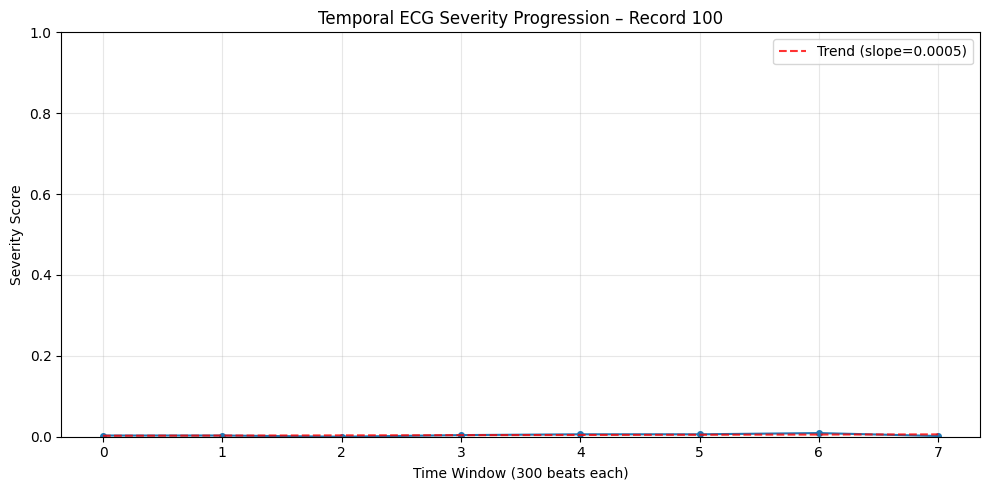


PATIENT ECG REPORT - Record 101

📊 OVERALL ASSESSMENT
   Disease Type: Mostly Normal Rhythm
   Severity Level: Mild (Score: 0.0)
   Total Beats Analyzed: 1865

📈 BEAT COMPOSITION
   Normal Beats: 99.8%
   Ventricular: 0.0%
   Atrial: 0.1%
   Conduction Issues: 0.0%
   Paced Beats: 0.0%
   Total Abnormal: 0.2%

📉 TEMPORAL PROGRESSION
   Trend: Stable
   Slope: -0.0001 (Confidence: 0.289)
   Mean Severity: 0.001
   Max Severity: 0.003
   Volatility: 0.001


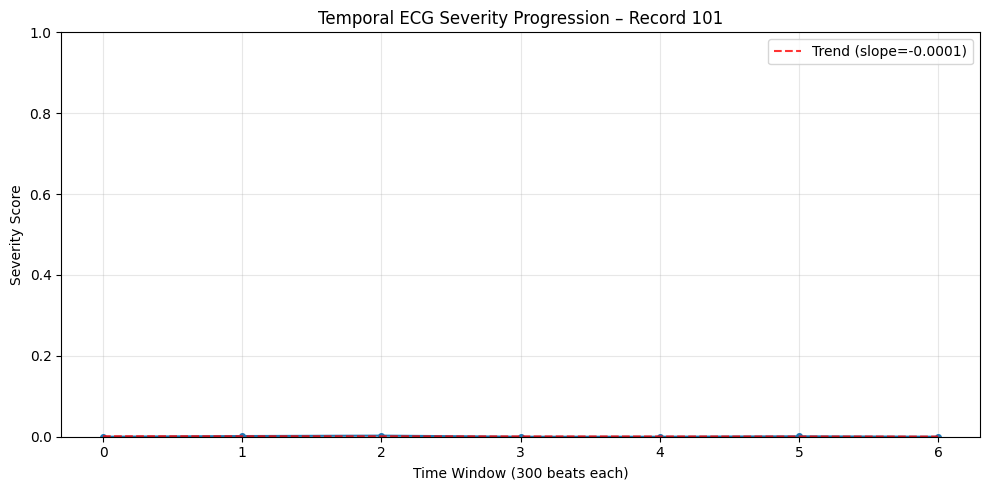


PATIENT ECG REPORT - Record 102

📊 OVERALL ASSESSMENT
   Disease Type: Paced Rhythm
   Severity Level: Mild (Score: 0.101)
   Total Beats Analyzed: 2187

📈 BEAT COMPOSITION
   Normal Beats: 4.5%
   Ventricular: 0.2%
   Atrial: 0.0%
   Conduction Issues: 0.0%
   Paced Beats: 95.3%
   Total Abnormal: 95.5%

📉 TEMPORAL PROGRESSION
   Trend: Stable
   Slope: 0.0054 (Confidence: 0.577)
   Mean Severity: 0.192
   Max Severity: 0.201
   Volatility: 0.022


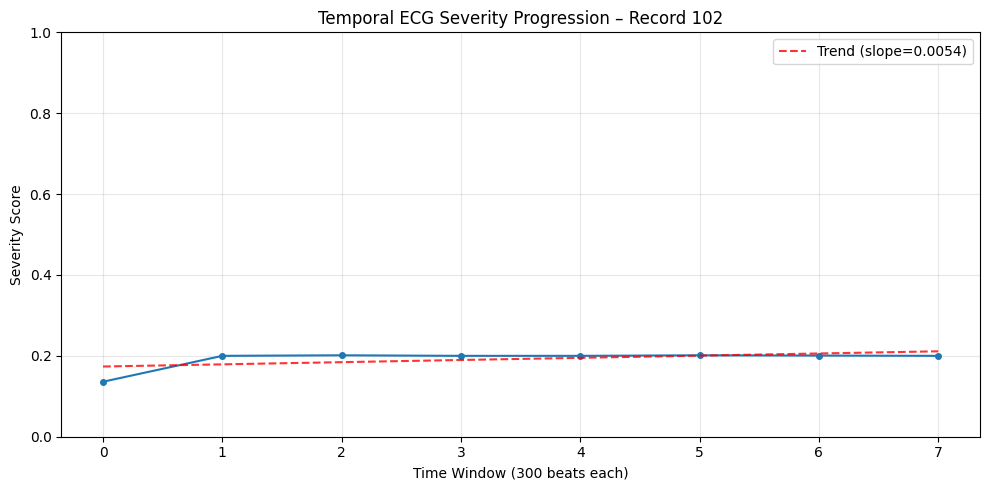


COHORT SUMMARY STATISTICS

Severity Level Distribution:
severity_level
Mild        41
Moderate     7
Name: count, dtype: int64

Disease Type Distribution:
disease_type
Mostly Normal Rhythm               29
Conduction Abnormality              7
Ventricular Arrhythmia Dominant     6
Paced Rhythm                        4
Mixed / Indeterminate Rhythm        1
Atrial Arrhythmia Dominant          1
Name: count, dtype: int64

Average Severity Score: 0.084
Average Abnormal Beat Ratio: 0.324


In [83]:
# Display a few example reports
print("\n" + "="*50)
print("EXAMPLE PATIENT REPORTS")
print("="*50)

for i in range(min(3, len(patient_df))):
    patient_id = patient_df.iloc[i]['patient_id']
    print_patient_report(all_reports[i])
    
    # Plot temporal progression if available
    if len(all_reports[i]['window_scores']) > 1:
        plot_temporal_progression(all_reports[i]['window_scores'], patient_id)

# Summary statistics
print("\n" + "="*50)
print("COHORT SUMMARY STATISTICS")
print("="*50)

print(f"\nSeverity Level Distribution:")
print(patient_df['severity_level'].value_counts())

print(f"\nDisease Type Distribution:")
print(patient_df['disease_type'].value_counts())

print(f"\nAverage Severity Score: {patient_df['ecg_severity_score'].mean():.3f}")
print(f"Average Abnormal Beat Ratio: {patient_df['abnormal_ratio'].mean():.3f}")

### STEP 14: Prepare for EHR Fusion

In [84]:
# ============================================
# PREPARE ECG FEATURES FOR EHR FUSION
# ============================================

# Select fusion-ready features
fusion_ready_columns = [
    'patient_id',
    'ecg_severity_score',
    'severity_level',
    'disease_type',
    'normal_ratio',
    'ventricular_ratio',
    'atrial_ratio',
    'conduction_ratio',
    'paced_ratio',
    'abnormal_ratio',
    'severity_trend',
    'trend_slope',
    'trend_confidence',
    'temporal_volatility',
    'mean_temporal_severity',
    'max_temporal_severity'
]

# Ensure all columns exist
available_fusion_cols = [col for col in fusion_ready_columns if col in patient_df.columns]
fusion_df = patient_df[available_fusion_cols].copy()

# Save fusion-ready dataset
fusion_df.to_csv('ecg_fusion_ready.csv', index=False)
print("\n✅ Fusion-ready ECG features saved to 'ecg_fusion_ready.csv'")

# Display first few rows
print("\nFusion-Ready ECG Features (first 5 patients):")
display(fusion_df.head())

print(f"\nFeatures available for fusion ({len(fusion_df.columns)} columns):")
print(fusion_df.columns.tolist())


✅ Fusion-ready ECG features saved to 'ecg_fusion_ready.csv'

Fusion-Ready ECG Features (first 5 patients):


,patient_id,ecg_severity_score,severity_level,disease_type,normal_ratio,ventricular_ratio,atrial_ratio,conduction_ratio,paced_ratio,abnormal_ratio,severity_trend,trend_slope,trend_confidence,temporal_volatility,mean_temporal_severity,max_temporal_severity
0,100,0.004,Mild,Mostly Normal Rhythm,0.986356,0.000440,0.013204,0.0,0.000000,0.013644,Stable,0.0005,0.425,0.004,0.004,0.009
1,101,0.000,Mild,Mostly Normal Rhythm,0.997855,0.000000,0.001072,0.0,0.000000,0.002145,Stable,-0.0001,0.289,0.001,0.001,0.003
2,102,0.101,Mild,Paced Rhythm,0.045267,0.001829,0.000000,0.0,0.952904,0.954733,Stable,0.0054,0.577,0.022,0.192,0.201
3,103,0.000,Mild,Mostly Normal Rhythm,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,Stable,0.0000,NaN,0.000,0.000,0.000
4,104,0.000,Mild,Paced Rhythm,0.076750,0.000898,0.000000,0.0,0.915619,0.923250,Stable,0.0028,0.797,0.006,0.188,0.197



Features available for fusion (16 columns):
['patient_id', 'ecg_severity_score', 'severity_level', 'disease_type', 'normal_ratio', 'ventricular_ratio', 'atrial_ratio', 'conduction_ratio', 'paced_ratio', 'abnormal_ratio', 'severity_trend', 'trend_slope', 'trend_confidence', 'temporal_volatility', 'mean_temporal_severity', 'max_temporal_severity']


### STEP 15: Generate Final Clinical Summary Report

In [85]:
def generate_clinical_summary(patient_df):
    """
    Generate a clinical summary report for the entire cohort
    """
    summary = {
        'total_patients': len(patient_df),
        'avg_severity': patient_df['ecg_severity_score'].mean(),
        'std_severity': patient_df['ecg_severity_score'].std(),
        
        'severity_counts': patient_df['severity_level'].value_counts().to_dict(),
        'disease_counts': patient_df['disease_type'].value_counts().to_dict(),
        
        'avg_composition': {
            'normal': patient_df['normal_ratio'].mean(),
            'ventricular': patient_df['ventricular_ratio'].mean(),
            'atrial': patient_df['atrial_ratio'].mean(),
            'conduction': patient_df['conduction_ratio'].mean(),
            'paced': patient_df['paced_ratio'].mean(),
            'abnormal': patient_df['abnormal_ratio'].mean()
        },
        
        'trend_distribution': patient_df['severity_trend'].value_counts().to_dict(),
        'avg_trend_slope': patient_df['trend_slope'].mean(),
        'avg_volatility': patient_df['temporal_volatility'].mean()
    }
    
    return summary

# Generate and display summary
clinical_summary = generate_clinical_summary(patient_df)

print("\n" + "="*60)
print("CLINICAL COHORT SUMMARY")
print("="*60)

print(f"\n📊 Cohort Size: {clinical_summary['total_patients']} patients")
print(f"\n📈 Severity (mean ± std): {clinical_summary['avg_severity']:.3f} ± {clinical_summary['std_severity']:.3f}")

print(f"\n📋 Severity Distribution:")
for level, count in clinical_summary['severity_counts'].items():
    print(f"   {level}: {count} ({count/clinical_summary['total_patients']*100:.1f}%)")

print(f"\n🏥 Disease Distribution:")
for disease, count in clinical_summary['disease_counts'].items():
    print(f"   {disease}: {count} ({count/clinical_summary['total_patients']*100:.1f}%)")

print(f"\n📊 Average Beat Composition:")
for beat_type, ratio in clinical_summary['avg_composition'].items():
    print(f"   {beat_type.capitalize()}: {ratio*100:.1f}%")

print(f"\n📉 Trend Distribution:")
for trend, count in clinical_summary['trend_distribution'].items():
    print(f"   {trend}: {count} ({count/clinical_summary['total_patients']*100:.1f}%)")

print(f"\n   Average Trend Slope: {clinical_summary['avg_trend_slope']:.4f}")
print(f"   Average Volatility: {clinical_summary['avg_volatility']:.3f}")
print("="*60)

# Save summary to file
import json
with open('clinical_cohort_summary.json', 'w') as f:
    json.dump(clinical_summary, f, indent=2)
print("\n✅ Clinical summary saved to 'clinical_cohort_summary.json'")


CLINICAL COHORT SUMMARY

📊 Cohort Size: 48 patients

📈 Severity (mean ± std): 0.084 ± 0.103

📋 Severity Distribution:
   Mild: 41 (85.4%)
   Moderate: 7 (14.6%)

🏥 Disease Distribution:
   Mostly Normal Rhythm: 29 (60.4%)
   Conduction Abnormality: 7 (14.6%)
   Ventricular Arrhythmia Dominant: 6 (12.5%)
   Paced Rhythm: 4 (8.3%)
   Mixed / Indeterminate Rhythm: 1 (2.1%)
   Atrial Arrhythmia Dominant: 1 (2.1%)

📊 Average Beat Composition:
   Normal: 67.6%
   Ventricular: 6.4%
   Atrial: 2.6%
   Conduction: 14.8%
   Paced: 7.6%
   Abnormal: 32.4%

📉 Trend Distribution:
   Stable: 42 (87.5%)
   Deteriorating: 4 (8.3%)
   Improving: 2 (4.2%)

   Average Trend Slope: 0.0009
   Average Volatility: 0.029

✅ Clinical summary saved to 'clinical_cohort_summary.json'


### STEP 16: Visualization Dashboard

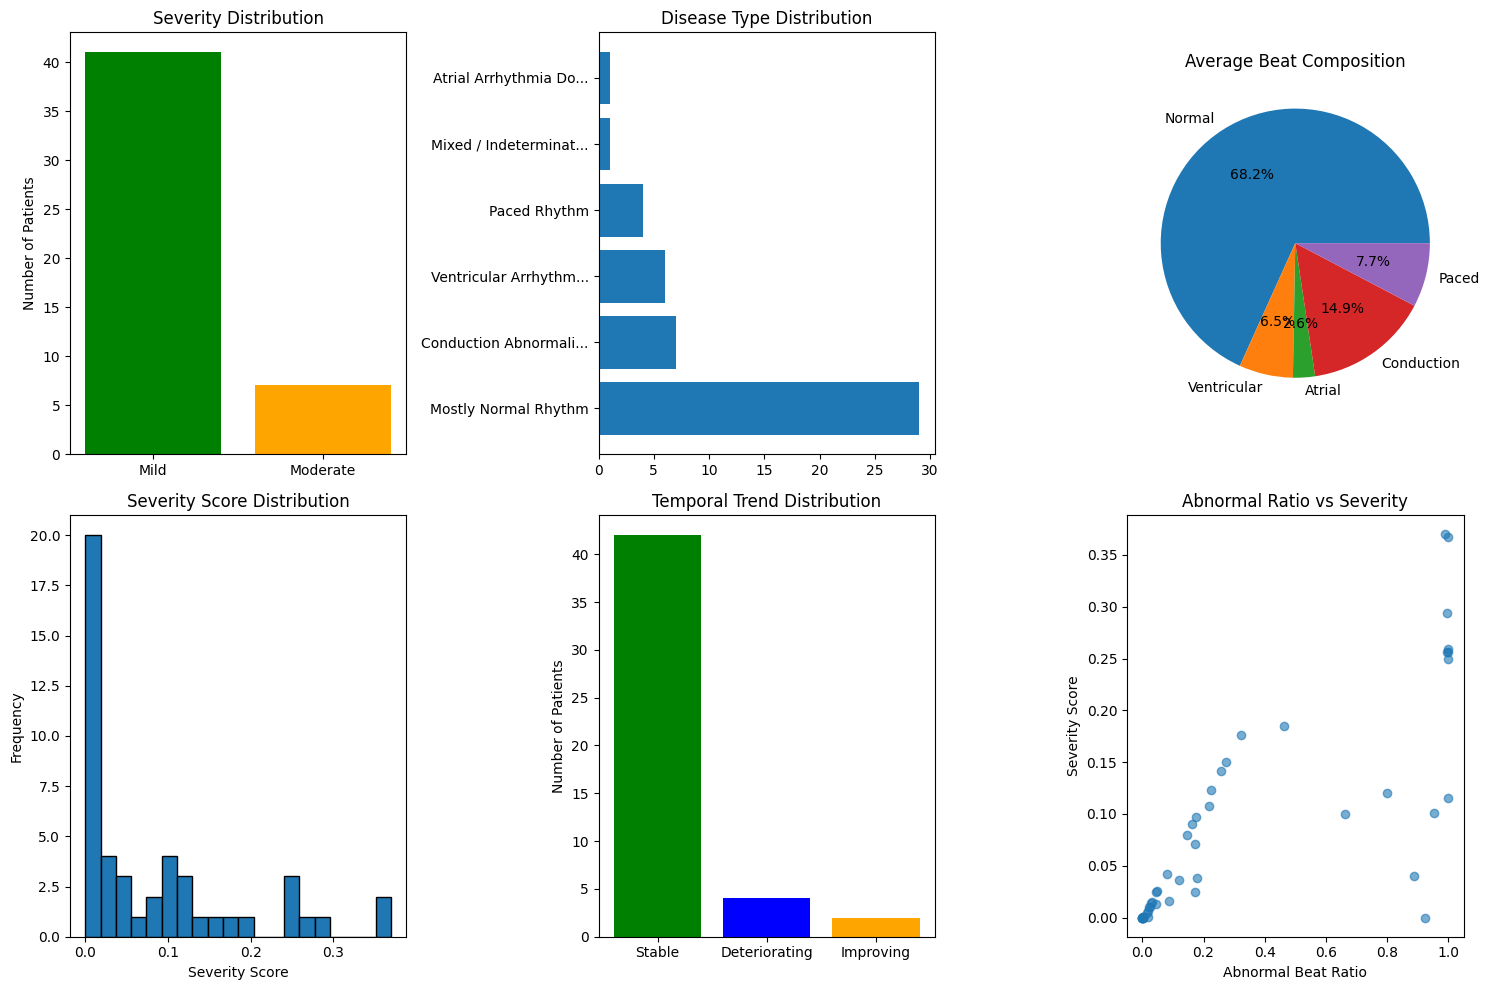


✅ Dashboard saved to 'ecg_dashboard.png'


In [86]:
def create_dashboard(patient_df):
    """
    Create comprehensive visualization dashboard
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. Severity distribution
    severity_counts = patient_df['severity_level'].value_counts()
    colors = ['green', 'orange', 'red']
    axes[0,0].bar(severity_counts.index, severity_counts.values, color=colors)
    axes[0,0].set_title('Severity Distribution')
    axes[0,0].set_ylabel('Number of Patients')
    
    # 2. Disease type distribution
    disease_counts = patient_df['disease_type'].value_counts()
    axes[0,1].barh(range(len(disease_counts)), disease_counts.values)
    axes[0,1].set_yticks(range(len(disease_counts)))
    axes[0,1].set_yticklabels([d[:20]+'...' if len(d)>20 else d for d in disease_counts.index])
    axes[0,1].set_title('Disease Type Distribution')
    
    # 3. Average beat composition
    avg_composition = {
        'Normal': patient_df['normal_ratio'].mean(),
        'Ventricular': patient_df['ventricular_ratio'].mean(),
        'Atrial': patient_df['atrial_ratio'].mean(),
        'Conduction': patient_df['conduction_ratio'].mean(),
        'Paced': patient_df['paced_ratio'].mean()
    }
    axes[0,2].pie(avg_composition.values(), labels=avg_composition.keys(), autopct='%1.1f%%')
    axes[0,2].set_title('Average Beat Composition')
    
    # 4. Severity score distribution
    axes[1,0].hist(patient_df['ecg_severity_score'], bins=20, edgecolor='black')
    axes[1,0].set_title('Severity Score Distribution')
    axes[1,0].set_xlabel('Severity Score')
    axes[1,0].set_ylabel('Frequency')
    
    # 5. Trend distribution
    trend_counts = patient_df['severity_trend'].value_counts()
    axes[1,1].bar(trend_counts.index, trend_counts.values, color=['green', 'blue', 'orange'])
    axes[1,1].set_title('Temporal Trend Distribution')
    axes[1,1].set_ylabel('Number of Patients')
    
    # 6. Abnormal ratio vs severity
    axes[1,2].scatter(patient_df['abnormal_ratio'], patient_df['ecg_severity_score'], alpha=0.6)
    axes[1,2].set_xlabel('Abnormal Beat Ratio')
    axes[1,2].set_ylabel('Severity Score')
    axes[1,2].set_title('Abnormal Ratio vs Severity')
    
    plt.tight_layout()
    plt.savefig('ecg_dashboard.png', dpi=150, bbox_inches='tight')
    plt.show()

# Create dashboard
create_dashboard(patient_df)
print("\n✅ Dashboard saved to 'ecg_dashboard.png'")

### STEP 17: Final Verification

In [87]:
print("\n" + "="*60)
print("PIPELINE COMPLETED SUCCESSFULLY")
print("="*60)

print("\n📁 Generated Files:")
print("   1. ecg_beat_classifier.h5 - Trained beat classification model")
print("   2. ecg_patient_summary.csv - Complete patient-level ECG reports")
print("   3. ecg_fusion_ready.csv - Fusion-ready features for EHR integration")
print("   4. clinical_cohort_summary.json - Clinical cohort summary")
print("   5. ecg_dashboard.png - Visualization dashboard")
print("   6. temporal_progression_*.png - Individual patient progression plots")
print("   7. confusion_matrix.png - Model performance visualization")

print("\n📊 Final Dataset Statistics:")
print(f"   Total patients processed: {len(patient_df)}")
print(f"   Total features per patient: {len(fusion_df.columns)}")
print(f"   Average beats per patient: {patient_df['total_beats'].mean():.0f}")
print(f"   Patients with temporal data: {(patient_df['window_scores'].apply(len) > 1).sum() if 'window_scores' in patient_df.columns else 0}")

print("\n✅ Pipeline complete! Ready for EHR fusion and disease progression modeling.")


PIPELINE COMPLETED SUCCESSFULLY

📁 Generated Files:
   1. ecg_beat_classifier.h5 - Trained beat classification model
   2. ecg_patient_summary.csv - Complete patient-level ECG reports
   3. ecg_fusion_ready.csv - Fusion-ready features for EHR integration
   4. clinical_cohort_summary.json - Clinical cohort summary
   5. ecg_dashboard.png - Visualization dashboard
   6. temporal_progression_*.png - Individual patient progression plots
   7. confusion_matrix.png - Model performance visualization

📊 Final Dataset Statistics:
   Total patients processed: 48
   Total features per patient: 16
   Average beats per patient: 2294
   Patients with temporal data: 0

✅ Pipeline complete! Ready for EHR fusion and disease progression modeling.
